In [1]:
%reset -f
from random import sample, choices
import itertools
import pandas as pd
import numpy as np
from utils import *
from wavhandler import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

In [2]:
filename = 'mosquitos.csv'
df = pd.read_csv(os.path.join(TEMP_DATADIR, filename), delimiter=';', index_col=0)

In [3]:
print(df.shape)
df.sample(5)

(279566, 16)


,fname,pow0,pow1,pow2,fr0,fr1,fr2,damping_0,damping_1,damping_2,names,pathlen,fnamelen,temp,humd,label
101434,F170301_105922_039_G_050_T_25.2_H_51.1,0.153771,0.001028,0.000127,1148.437500,2298.828125,3447.265625,0.021259,0.011895,0.005666,/home/kalfasyan/data/insects/Wingbeats/Ae. alb...,9,9,25.2,51.1,Ae. albopictus
212333,F161220_191503_093_G_050,0.040789,0.009157,0.001568,392.578125,792.968750,1188.476562,0.034826,0.049261,0.017666,/home/kalfasyan/data/insects/Wingbeats/C. quin...,9,5,NaN,NaN,C. quinquefasciatus
161097,F170201_230126_093_G_050,0.139732,0.058833,0.010069,377.929688,747.070312,1094.726562,0.074935,0.035948,0.012935,/home/kalfasyan/data/insects/Wingbeats/An. ara...,9,5,NaN,NaN,An. arabiensis
62293,F170209_165233_242_G_050,0.147702,0.043849,0.014633,542.968750,1066.406250,1656.250000,0.046763,0.013736,0.017983,/home/kalfasyan/data/insects/Wingbeats/Ae. aeg...,9,5,NaN,NaN,Ae. aegypti
35574,F170211_085941_097_G_050,0.111529,0.063324,0.025073,447.265625,890.625000,1347.656250,0.081878,0.035088,0.020290,/home/kalfasyan/data/insects/Wingbeats/Ae. aeg...,9,5,NaN,NaN,Ae. aegypti


In [4]:
# CREATING DATE COLUMN
df['date'] = df['fname'].apply(lambda x: pd.to_datetime(x.split('_')[0] + x.split('_')[1], format='F%y%m%d%H%M%S'))
df['date'] = df.date.dt.to_period('d').apply(lambda x: x.strftime('%Y%m%d'))
print(df.date.head(2))

0    20170209
1    20170209
Name: date, dtype: object


## Barplots of data signals collected per day

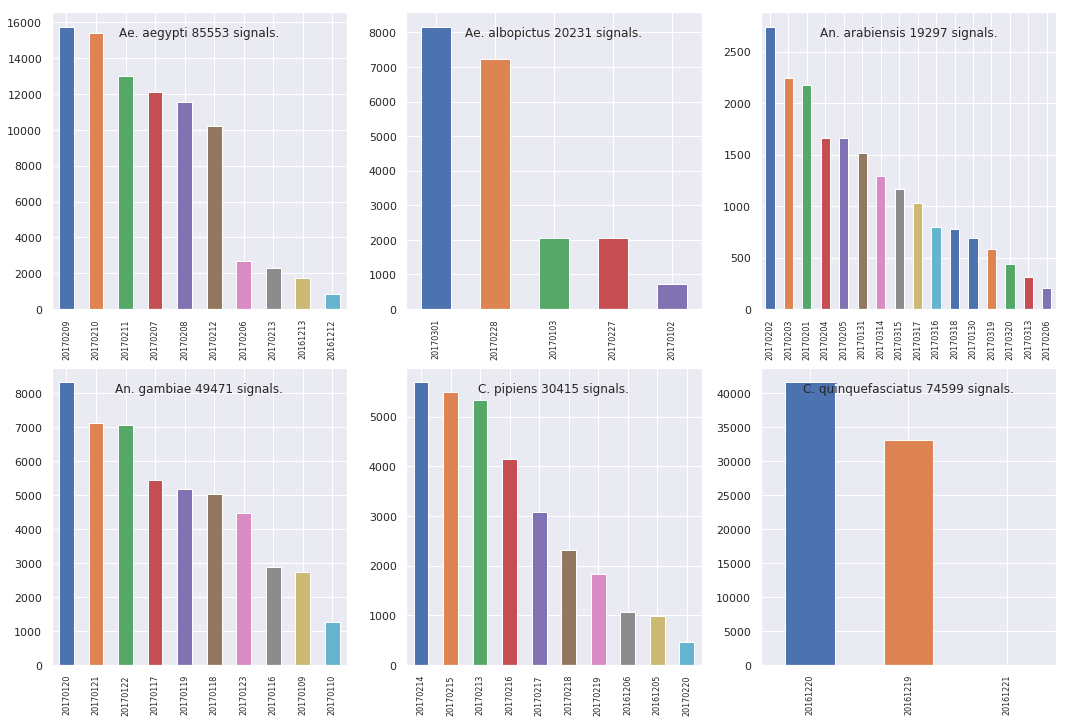

In [5]:
plt.figure(figsize=(18,12))
plt.tight_layout()
for q, (i, sub) in enumerate(df.groupby('label')):
    plt.subplot(2,3,q+1)
    plt.title(sub.label.unique()[0] +' '+ str(sub.shape[0])+' signals.', y=0.9)
    sub.date.value_counts().plot(kind='bar')
    plt.xticks(rotation=90, fontsize=8)

In [6]:
# for q, (i, sub) in enumerate(df.groupby('label')):
#     print(sub.date.value_counts())

## Random signal PSD example

100%|██████████| 2/2 [00:00<00:00, 952.93it/s]


Text(0.5, 0, 'Frequency (Hz)')

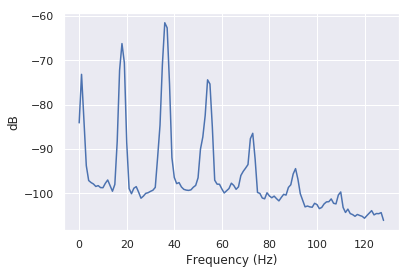

In [76]:
class_label = 'An. gambiae'
random_signal = read_simple(df[(df.label==class_label)].sample(2).names.tolist())[0]
plt.plot(transform_data(random_signal.T)[0])
plt.ylabel('dB'); plt.xlabel('Frequency (Hz)')

# Analysis

In [77]:
class_label = 'An. gambiae'
periods = df[df.label==class_label].date.value_counts().index.tolist()
periods = [periods[i] for i in range(len(periods))]
print('Periods for class \"{}\": \t{}'.format(class_label, periods))

Periods for class "An. gambiae": 	['20170120', '20170121', '20170122', '20170117', '20170119', '20170118', '20170123', '20170116', '20170109', '20170110']


In [78]:
pair_combs = []
for i in itertools.combinations_with_replacement(periods, r=2):
    pair_combs.append(i)
print('Example combinations for periods of class \"{}\": \t{}'.format(class_label, pair_combs[:3]))
print('Total nr. of combinations: \t{}'.format(len(pair_combs)))

Example combinations for periods of class "An. gambiae": 	[('20170120', '20170120'), ('20170120', '20170121'), ('20170120', '20170122')]
Total nr. of combinations: 	55


In [79]:
def upper_triangular(a, metric='euclidean'):
    from scipy.spatial.distance import pdist, squareform
    dist_mat = squareform(pdist(a.T, metric=metric))
    up_tr = dist_mat[np.triu_indices(len(dist_mat))]
    return up_tr, dist_mat

def get_data_for_day(selected_day=None, df=None, samples=100):
    X_names = df[(df.label==class_label) & (df.date == selected_day)].names
    X_data = read_simple(sample(X_names.tolist(), samples))[0].T
#     X_data = read_simple(X_names)[0].T
    X = transform_data(X_data)
    y = np.ones(len(X_names))
    return X, y

iters = 1000
corrs = {}
for p, pair in enumerate(pair_combs):
#     if p == 0:
#         break
    print(p/len(pair_combs)*100.)
    # Creating matrices for the two days of the pair.
    # This returns the "transformed" signals i.e. PSDs
    X1, _ = get_data_for_day(selected_day=pair[0], df=df[df.label==class_label], samples=100)
    X2, _ = get_data_for_day(selected_day=pair[1], df=df[df.label==class_label], samples=100)
    
    # BOOTSTRAP
    corrs[pair] = []
    for it in range(iters):
        samplesize = np.min([X1.shape[0], X2.shape[0]])

        # Sampling with replacement the data of the days - for as many times as "iters"
        bootstrap_sample = choices(list(range(0,samplesize)), k=samplesize)
        #np.random.randint(0,samplesize,size=samplesize)

        d1,_ = upper_triangular(X1[bootstrap_sample,:])
        d2,_ = upper_triangular(X2[bootstrap_sample,:])
        corrs[pair].append(np.corrcoef(d1,d2)[0,1])


0.0


  0%|          | 0/100 [00:00<?, ?it/s]

1.8181818181818181


100%|██████████| 100/100 [00:00<00:00, 1539.49it/s]


3.6363636363636362


100%|██████████| 100/100 [00:00<00:00, 1297.29it/s]


5.454545454545454


100%|██████████| 100/100 [00:00<00:00, 1578.80it/s]


7.2727272727272725


100%|██████████| 100/100 [00:00<00:00, 1716.19it/s]


9.090909090909092


100%|██████████| 100/100 [00:00<00:00, 1409.76it/s]


10.909090909090908


100%|██████████| 100/100 [00:00<00:00, 1381.40it/s]


12.727272727272727


100%|██████████| 100/100 [00:00<00:00, 1552.25it/s]


14.545454545454545


100%|██████████| 100/100 [00:00<00:00, 1886.51it/s]


16.363636363636363


100%|██████████| 100/100 [00:00<00:00, 1881.06it/s]


18.181818181818183


100%|██████████| 100/100 [00:00<00:00, 1747.01it/s]

20.0



100%|██████████| 100/100 [00:00<00:00, 1481.69it/s]


21.818181818181817


  0%|          | 0/100 [00:00<?, ?it/s]

23.636363636363637


100%|██████████| 100/100 [00:00<00:00, 1670.51it/s]


25.454545454545453


100%|██████████| 100/100 [00:00<00:00, 1686.24it/s]


27.27272727272727


100%|██████████| 100/100 [00:00<00:00, 1589.12it/s]


29.09090909090909


100%|██████████| 100/100 [00:00<00:00, 1440.49it/s]


30.909090909090907


  0%|          | 0/100 [00:00<?, ?it/s]

32.72727272727273


100%|██████████| 100/100 [00:00<00:00, 1650.30it/s]


34.54545454545455


  0%|          | 0/100 [00:00<?, ?it/s]

36.36363636363637


100%|██████████| 100/100 [00:00<00:00, 1296.68it/s]


38.18181818181819


100%|██████████| 100/100 [00:00<00:00, 1588.81it/s]


40.0


100%|██████████| 100/100 [00:00<00:00, 1661.68it/s]


41.81818181818181


100%|██████████| 100/100 [00:00<00:00, 1451.77it/s]


43.63636363636363


100%|██████████| 100/100 [00:00<00:00, 1682.59it/s]


45.45454545454545


  0%|          | 0/100 [00:00<?, ?it/s]

47.27272727272727


100%|██████████| 100/100 [00:00<00:00, 1833.70it/s]


49.09090909090909


  0%|          | 0/100 [00:00<?, ?it/s]

50.90909090909091


  0%|          | 0/100 [00:00<?, ?it/s]

52.72727272727272


100%|██████████| 100/100 [00:00<00:00, 1606.43it/s]


54.54545454545454


100%|██████████| 100/100 [00:00<00:00, 1386.39it/s]


56.36363636363636


100%|██████████| 100/100 [00:00<00:00, 1698.01it/s]


58.18181818181818


  0%|          | 0/100 [00:00<?, ?it/s]

60.0


100%|██████████| 100/100 [00:00<00:00, 1825.50it/s]


61.81818181818181


100%|██████████| 100/100 [00:00<00:00, 1818.05it/s]

63.63636363636363



  0%|          | 0/100 [00:00<?, ?it/s]

65.45454545454545


100%|██████████| 100/100 [00:00<00:00, 1695.90it/s]


67.27272727272727


  0%|          | 0/100 [00:00<?, ?it/s]

69.0909090909091


100%|██████████| 100/100 [00:00<00:00, 1838.39it/s]

70.9090909090909



100%|██████████| 100/100 [00:00<00:00, 1806.44it/s]


72.72727272727273


100%|██████████| 100/100 [00:00<00:00, 1830.74it/s]

74.54545454545455



100%|██████████| 100/100 [00:00<00:00, 1706.76it/s]


76.36363636363637


100%|██████████| 100/100 [00:00<00:00, 1555.04it/s]


78.18181818181819


  0%|          | 0/100 [00:00<?, ?it/s]

80.0


100%|██████████| 100/100 [00:00<00:00, 1818.63it/s]


81.81818181818183


100%|██████████| 100/100 [00:00<00:00, 1797.96it/s]

83.63636363636363



  0%|          | 0/100 [00:00<?, ?it/s]

85.45454545454545


100%|██████████| 100/100 [00:00<00:00, 1816.77it/s]

87.27272727272727



100%|██████████| 100/100 [00:00<00:00, 1783.55it/s]

89.0909090909091



100%|██████████| 100/100 [00:00<00:00, 1782.07it/s]

90.9090909090909



  0%|          | 0/100 [00:00<?, ?it/s]

92.72727272727272


100%|██████████| 100/100 [00:00<00:00, 1830.48it/s]

94.54545454545455



100%|██████████| 100/100 [00:00<00:00, 1800.83it/s]

96.36363636363636



100%|██████████| 100/100 [00:00<00:00, 1835.65it/s]

98.18181818181819


### 95% confidence interval for all pair combinations

In [93]:
pd.concat([pd.DataFrame.from_dict(corrs, orient='index').T.quantile(0.025), pd.DataFrame.from_dict(corrs, orient='index').T.quantile(0.975)], axis=1).sort_values(by=0.025,ascending=False)

,0.025,0.975
"(20170109, 20170110)",0.979572,0.994696
"(20170110, 20170110)",0.977503,0.994441
"(20170109, 20170109)",0.977185,0.995747
"(20170116, 20170116)",0.975995,0.994130
"(20170120, 20170120)",0.956743,0.991678
"(20170121, 20170122)",0.956410,0.988230
"(20170123, 20170123)",0.955105,0.987890
"(20170121, 20170123)",0.954528,0.988166
"(20170117, 20170117)",0.951196,0.989094
"(20170122, 20170122)",0.948552,0.987912


### Median (quantile:0.5)

In [81]:
pd.DataFrame.from_dict(corrs, orient='index').T.median().sort_values(ascending=False) # quantile(0.5)

(20170109, 20170109)    0.990760
(20170109, 20170110)    0.989807
(20170116, 20170116)    0.988473
(20170110, 20170110)    0.988463
(20170120, 20170120)    0.981987
(20170121, 20170122)    0.978330
(20170120, 20170121)    0.977810
(20170123, 20170123)    0.977473
(20170117, 20170117)    0.976382
(20170121, 20170123)    0.976180
(20170122, 20170122)    0.975925
(20170118, 20170118)    0.971964
(20170120, 20170122)    0.970835
(20170119, 20170119)    0.968520
(20170117, 20170118)    0.966993
(20170121, 20170121)    0.965952
(20170119, 20170118)    0.963308
(20170120, 20170123)    0.957188
(20170120, 20170118)    0.953144
(20170122, 20170119)    0.952879
(20170122, 20170123)    0.950079
(20170117, 20170119)    0.947787
(20170120, 20170119)    0.944812
(20170119, 20170123)    0.927753
(20170121, 20170119)    0.921031
(20170122, 20170117)    0.911514
(20170122, 20170118)    0.905109
(20170120, 20170117)    0.899311
(20170121, 20170117)    0.898004
(20170121, 20170118)    0.896291
(20170117,

### Median correlation of each day with the rest

      stats   periods
0  0.948978  20170120
1  0.909518  20170121
2  0.930796  20170122


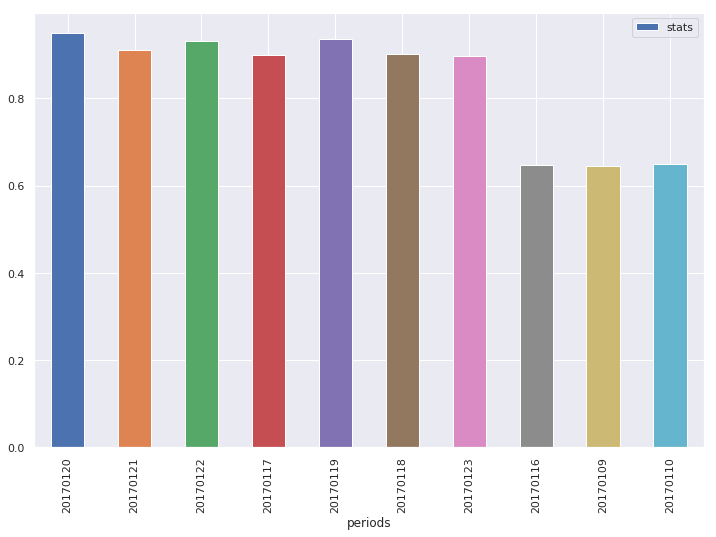

In [82]:
def get_period_stat(p):
    stats = {}
    for i in pair_combs:
        if periods[p] in i:
            stats[i] = np.median(corrs[i])
    return stats
df_periodstats = pd.DataFrame([(np.median(list(get_period_stat(i).values())), periods[i]) for i in range(len(periods))], columns=['stats','periods'])
print(df_periodstats.head(3))
df_periodstats.plot.bar(x='periods',y='stats', figsize=(12,8))

### Why are some days so poorly correlated with others?

In [87]:
day = '20170110'
vsday = '20170123'
X, _ = get_data_for_day(selected_day=day, df=df[df.label==class_label], samples=1000)
print("There are {} signals for day {}".format(df[(df.label==class_label) & (df.date==day)].shape[0], day))
print("In class {}, there are in total {} signals".format(class_label, df[df.label==class_label].shape[0]))
print("{0:.2f}% of the signals belong to that day".format(df[(df.label==class_label) & (df.date==day)].shape[0]/df[df.label==class_label].shape[0]*100.))

100%|██████████| 1000/1000 [00:00<00:00, 1817.69it/s]


There are 1262 signals for day 20170110
In class An. gambiae, there are in total 49471 signals
2.55% of the signals belong to that day


### Distance matrix for that day

100%|██████████| 1000/1000 [00:00<00:00, 1883.44it/s]


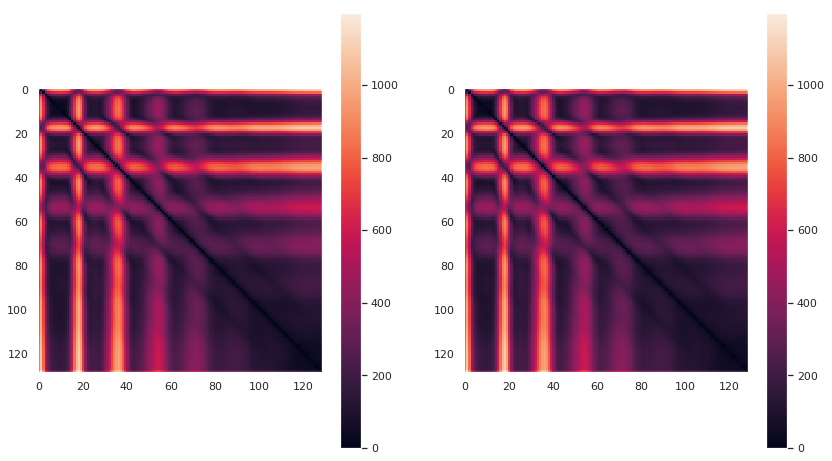

In [94]:
plt.figure(figsize=(14,8)); plt.tight_layout();
plt.subplot(1,2,1)
plt.imshow(upper_triangular(X, metric='euclidean')[1])
plt.colorbar()
plt.grid(False)
plt.subplot(1,2,2)
Xb, _ = get_data_for_day(selected_day=vsday, df=df[df.label==class_label], samples=1000)
plt.imshow(upper_triangular(X, metric='euclidean')[1])
plt.colorbar()
plt.grid(False)

### Histograms of 'fr0' for selected day vs another day

(0, 3600)

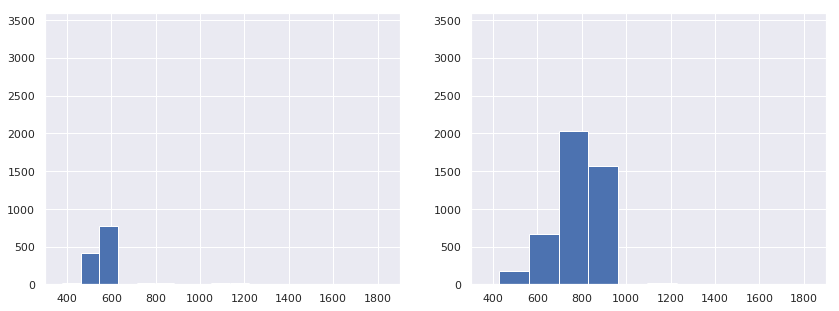

In [89]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
df[(df.label==class_label) & (df.date==day)].fr0.hist()
plt.xlim(300,1900)
plt.ylim(0,3600)
plt.subplot(1,2,2)
df[(df.label==class_label) & (df.date==vsday)].fr0.hist()
plt.xlim(300,1900)
plt.ylim(0,3600)

### temperature/humidity measurements for all days

In [90]:
for i, sub in df[df.label==class_label].groupby('date'):
    print('Day: {} , \nvalue counts:\n{}\n'.format(i,sub.temp.value_counts()))
    

Day: 20170109 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170110 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170116 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170117 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170118 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170119 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170120 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170121 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170122 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170123 , 
value counts:
Series([], Name: temp, dtype: int64)



#  
#  

## Distance Matrix

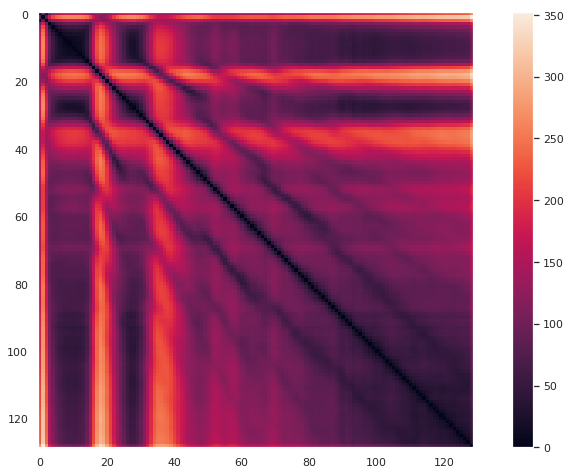

In [260]:
plt.figure(figsize=(14,8))
plt.imshow(upper_triangular(X2, metric='euclidean')[1])
plt.colorbar()
plt.grid(False)

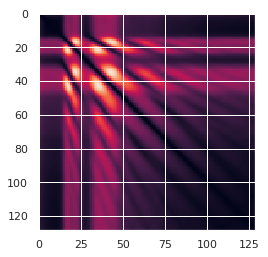

In [191]:
plt.imshow(upper_triangular(X1, metric='cosine')[1])

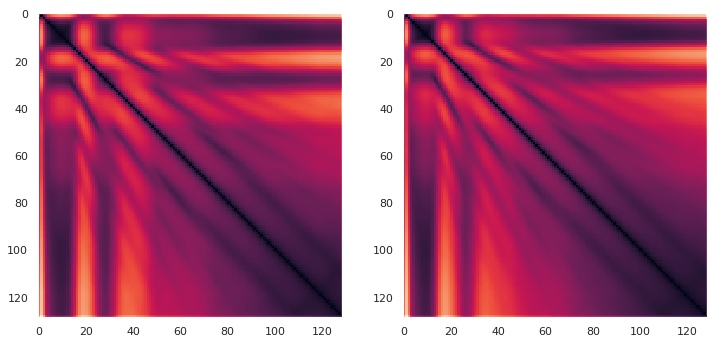

In [79]:
from scipy.spatial.distance import pdist, squareform
D1 = squareform(pdist(X1.T, metric='euclidean'))
D2 = squareform(pdist(X2.T, metric='euclidean'))
plt.figure(figsize=(12,8))
plt.subplot(1,2,1); plt.imshow(D1); plt.grid(False)
plt.subplot(1,2,2); plt.imshow(D2); plt.grid(False)

In [80]:
np.corrcoef(D1[np.triu_indices(len(D1))],
            D2[np.triu_indices(len(D2))])

array([[1.       , 0.9527434],
       [0.9527434, 1.       ]])

In [12]:
# df_x1 = pd.DataFrame(X1.T).describe()
# df_x2 = pd.DataFrame(X2.T).describe()

In [9]:
# X = np.vstack((X1,X2))
# y = np.vstack((y1.reshape(-1,1),y2.reshape(-1,1))).ravel()

# X, y = shuffle(X, y, random_state=3)

# from imblearn.under_sampling import RandomUnderSampler
# ros = RandomUnderSampler(random_state=0)
# ros.fit(X,y)
# X, y = ros.fit_resample(X,y)
# print('After undersampling: \n{}\n'.format(pd.DataFrame(y).iloc[:,0].value_counts()))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# from sklearn.tree import DecisionTreeClassifier
# classifier = DecisionTreeClassifier(random_state=0)
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)

# ac = accuracy_score(y_test, y_pred)
# #cv_ac = cross_val_score(classifier, X, y, cv=3, scoring='accuracy')
# print("ac: %f" % ac)
# #print("Name: %s, cv_ac: %f" % ('...', np.mean(cv_ac)))

After undersampling: 
1.0    15393
0.0    15393
Name: 0, dtype: int64

ac: 0.580221


In [10]:
# feature_importances = pd.DataFrame(classifier.feature_importances_,
#                                     columns=['importance']).sort_values('importance', ascending=False)
# feature_importances.head(10)